## Zestaw 3

### Zadanie 1 

Uczenie CD (ang. Contrastive Divergence).

Zaimplementować samodzielnie (na podstawie wykładu) uczenie typu CD, pisząc procedury przejścia pomiędzy warstwą "wizualną" i ukrytą w sieci RBM. Zamodelować macierz W, wektory h i v oraz proces losowania. Sprawdzić na prostym przykładzie.

- CD (Contrastive Divergence) - jest iteracyjnym algorytmem stosowanym w szkoleniu RBM, które są rodzajem probabilistycznego modelu graficznego używanego do redukcji wymiarowości, uczenia się cech i filtrowania kolaboracyjnego . Podstawowym celem CD jest oszacowanie gradientu funkcji logarytmu wiarygodności powiązanej z RBM.
- RBM (Restricted Boltzman Machine) - składają się z widocznych i ukrytych warstw, w których węzły w warstwach są ze sobą połączone, ale nie mają połączeń w obrębie tej samej warstwy. CD działa poprzez aktualizację wag tych połączeń w celu zminimalizowania różnicy między obserwowanymi danymi a zrekonstruowanymi danymi wygenerowanymi przez RBM.

Etapy implementacji:
- Zainicjować parametry modelu RBM (W - wagi, a - widoczne i  b - ukryte warstwy, współczynniki uczenia, liczba epok itp.),
- Obliczanie prawdopodobieństwa ukrytych wag,
- Rekonstrukcja widocznych wag,
- Obliczanie gradientu,
- Aktualizacja wag,
- Powtarzanie procesu aż do osiągnięcia zadowalających wyników.

Prawdopodobieństwa w warstwie ukrytej: [0.57055937 0.48166488 0.47394653]
Rekonstrukcja danych wejściowych: [0.55690357 0.47243672 0.52651428 0.49664054 0.46039233 0.44007432]


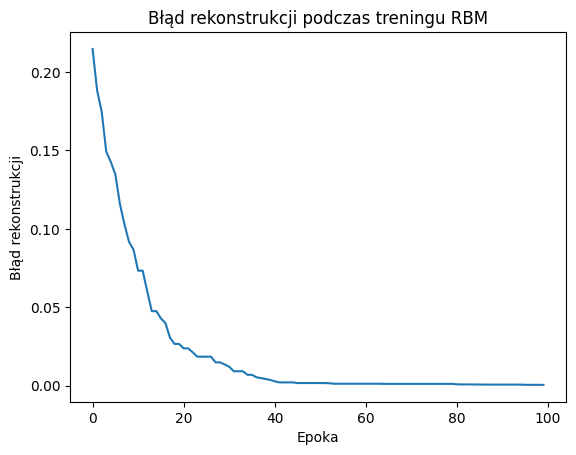

In [2]:
import numpy as np
import matplotlib.pyplot as plt

class RBM:
    def __init__(self, n_visible, n_hidden, learning_rate=0.1):
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.learning_rate = learning_rate

        # Inicjalizacja wag i przesunięć
        self.W = np.random.randn(n_visible, n_hidden) * 0.1
        self.b_visible = np.zeros(n_visible)
        self.b_hidden = np.zeros(n_hidden)

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sample_prob(self, probs):
        """Losowanie stanów (0 lub 1) na podstawie prawdopodobieństw."""
        return np.random.binomial(1, probs)

    def train(self, v_input, k=1):
        # Faza pozytywna
        h_prob = self.sigmoid(np.dot(v_input, self.W) + self.b_hidden)
        h_sample = self.sample_prob(h_prob)
        
        # Faza negatywna (rekonstrukcja)
        for _ in range(k):
            v_reconstructed_prob = self.sigmoid(np.dot(h_sample, self.W.T) + self.b_visible)
            v_reconstructed_sample = self.sample_prob(v_reconstructed_prob)
            h_reconstructed_prob = self.sigmoid(np.dot(v_reconstructed_sample, self.W) + self.b_hidden)
            h_sample = self.sample_prob(h_reconstructed_prob)  # Aktualizacja h_sample dla kolejnych iteracji
        
        # Aktualizacja wag i przesunięć
        pos_grad = np.outer(v_input, h_prob)   # Pozytywne skojarzenia
        neg_grad = np.outer(v_reconstructed_sample, h_reconstructed_prob)  # Negatywne skojarzenia
        self.W += self.learning_rate * (pos_grad - neg_grad)
        self.b_visible += self.learning_rate * (v_input - v_reconstructed_sample)
        self.b_hidden += self.learning_rate * (h_prob - h_reconstructed_prob)

    def run_visible(self, v_input):
        """Obliczanie prawdopodobieństw w warstwie ukrytej dla danych wejściowych."""
        h_prob = self.sigmoid(np.dot(v_input, self.W) + self.b_hidden)
        return h_prob

    def reconstruct(self, v_input):
        """Rekonstrukcja danych wejściowych."""
        h_prob = self.run_visible(v_input)
        v_reconstructed = self.sigmoid(np.dot(h_prob, self.W.T) + self.b_visible)
        return v_reconstructed

# Przykładowe użycie
np.random.seed(42)  # Ustalanie ziarna dla powtarzalności
n_visible = 6
n_hidden = 3
learning_rate = 0.1
rbm = RBM(n_visible=n_visible, n_hidden=n_hidden, learning_rate=learning_rate)

# Przykładowe dane treningowe - binarne
data = np.array([1, 0, 1, 0, 1, 0])
rbm.train(data, k=1)

print("Prawdopodobieństwa w warstwie ukrytej:", rbm.run_visible(data))
print("Rekonstrukcja danych wejściowych:", rbm.reconstruct(data))

# Wizualizacja rekonstrukcji podczas treningu na kilku epokach
epochs = 100
errors = []

for epoch in range(epochs):
    rbm.train(data, k=1)
    reconstructed_data = rbm.reconstruct(data)
    error = np.mean((data - reconstructed_data) ** 2)
    errors.append(error)

# Wykres błędu rekonstrukcji
plt.plot(errors)
plt.xlabel("Epoka")
plt.ylabel("Błąd rekonstrukcji")
plt.title("Błąd rekonstrukcji podczas treningu RBM")
plt.show()

### Zadanie 2 

Sieć RBM (Restricted Boltzmann Machine).

Przewidywane preferencje dla nowego użytkownika: [0.99859923 0.16113958 0.99985048 0.00195267 0.81142797]


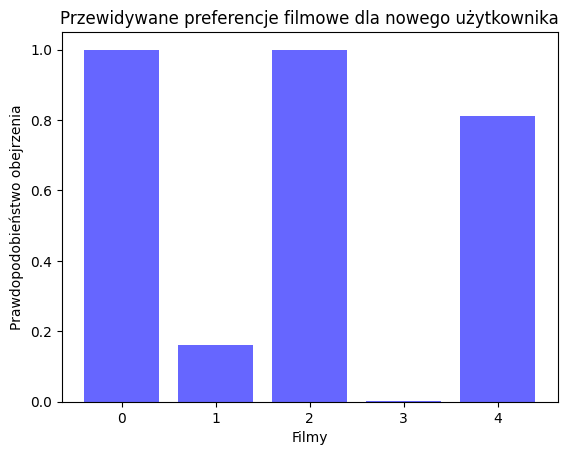

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Klasa RBM z implementacją mechanizmu CD
class RBM:
    def __init__(self, n_visible, n_hidden, learning_rate=0.1):
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.learning_rate = learning_rate

        # Inicjalizacja wag i przesunięć
        self.W = np.random.randn(n_visible, n_hidden) * 0.1
        self.b_visible = np.zeros(n_visible)
        self.b_hidden = np.zeros(n_hidden)

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sample_prob(self, probs):
        """Losowanie stanów (0 lub 1) na podstawie prawdopodobieństw."""
        return np.random.binomial(1, probs)

    def train(self, data, k=1, epochs=10):
        # Trening sieci RBM
        for epoch in range(epochs):
            for user in data:
                # Faza pozytywna
                h_prob = self.sigmoid(np.dot(user, self.W) + self.b_hidden)
                h_sample = self.sample_prob(h_prob)
                
                # Faza negatywna (rekonstrukcja)
                for _ in range(k):
                    v_reconstructed_prob = self.sigmoid(np.dot(h_sample, self.W.T) + self.b_visible)
                    v_reconstructed_sample = self.sample_prob(v_reconstructed_prob)
                    h_reconstructed_prob = self.sigmoid(np.dot(v_reconstructed_sample, self.W) + self.b_hidden)
                    h_sample = self.sample_prob(h_reconstructed_prob)
                
                # Aktualizacja wag i przesunięć
                pos_grad = np.outer(user, h_prob)   # Pozytywne skojarzenia
                neg_grad = np.outer(v_reconstructed_sample, h_reconstructed_prob)  # Negatywne skojarzenia
                self.W += self.learning_rate * (pos_grad - neg_grad)
                self.b_visible += self.learning_rate * (user - v_reconstructed_sample)
                self.b_hidden += self.learning_rate * (h_prob - h_reconstructed_prob)

    def predict(self, v_input):
        """Przewidywanie wartości wizualnej na podstawie reprezentacji ukrytej."""
        h_prob = self.sigmoid(np.dot(v_input, self.W) + self.b_hidden)
        v_reconstructed = self.sigmoid(np.dot(h_prob, self.W.T) + self.b_visible)
        return v_reconstructed

# Przykładowe dane: preferencje filmowe użytkowników (1 = oglądane, 0 = nie oglądane)
movie_data = np.array([
    [1, 0, 1, 0, 1],  # Użytkownik 1
    [0, 1, 0, 1, 0],  # Użytkownik 2
    [1, 1, 1, 0, 0],  # Użytkownik 3
    [0, 0, 1, 1, 1],  # Użytkownik 4
])

# Ustalanie parametrów RBM
n_visible = movie_data.shape[1]  # Liczba filmów
n_hidden = 3  # Liczba neuronów ukrytych
learning_rate = 0.1

# Inicjalizacja i trening RBM
rbm = RBM(n_visible, n_hidden, learning_rate)
rbm.train(movie_data, k=1, epochs=5000)

# Przewidywanie na podstawie ukrytej reprezentacji dla nowego użytkownika
new_user = np.array([1, 0, 1, 0, 0])  # Użytkownik obejrzał filmy 1 i 3
predicted = rbm.predict(new_user)
print("Przewidywane preferencje dla nowego użytkownika:", predicted)

# Rysowanie wykresu przewidywanych preferencji
plt.bar(range(n_visible), predicted, color='blue', alpha=0.6)
plt.xlabel("Filmy")
plt.ylabel("Prawdopodobieństwo obejrzenia")
plt.title("Przewidywane preferencje filmowe dla nowego użytkownika")
plt.show()